In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P1'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here are our files:")
!ls -lasth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P1'
/content/gdrive/MyDrive/GIA/VCA/P1
/content/gdrive/MyDrive/GIA/VCA/P1

And here are our files:
total 20M
4.9M -rw------- 1 root root 4.9M Apr  9 17:00 pt_DA.pth
4.9M -rw------- 1 root root 4.9M Apr  9 17:00 pt_no_DA.pth
4.9M -rw------- 1 root root 4.9M Apr  9 17:00 npt_DA.pth
4.9M -rw------- 1 root root 4.9M Apr  9 16:59 npt_no_DA.pth
4.0K drwx------ 3 root root 4.0K Mar 27 10:29 ship_dataset


#### Importamos las bibliotecas necesarias para realizar la práctica.

In [2]:
import os, glob, time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

seed = 42
batch_size = 64

## **Tarea 1**: Implementación de Dataset class personalizada para la carga del dataset y su uso en tareas de clasificación.

#### Creamos una clase `Dataset` que hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [3]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

        # leemos el csv y recortamos la cabecera
        lines = open(csv_path).readlines()[1:]
        self.img_files = list()
        self.labels = list()
        self.names = list()

        for line in lines:
            filename, label = line.split(";")
            img = read_image(os.path.join(image_path, filename))
            img = self.transform(img)
            self.img_files.append(img)
            self.labels.append(torch.tensor(int(label), dtype=torch.float32))
            self.names.append(os.path.splitext(os.path.basename(filename))[0])

        print("Imágenes en el dataset:", len(self.img_files))

    def __getitem__(self, index):
        image = self.img_files[index]
        label = self.labels[index]
        name = self.names[index]

        return image, label, name

    def __len__(self):
        return len(self.img_files)

#### Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [4]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

#### Indicamos el directorio de las imágenes y el archivo CSV de etiquetas. Creamos transformaciones personalizadas para las imágenes e instanciamos el dataset ship_dataset. Finalmente, imprimimos el tamaño del dataset.

In [5]:
dir = "ship_dataset"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en el dataset: 294
Tamaño del dataset completo: 294


####  Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

<ipython-input-4-165f0e13db72>:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  new_image[:,:] = tensor[0,:,:]


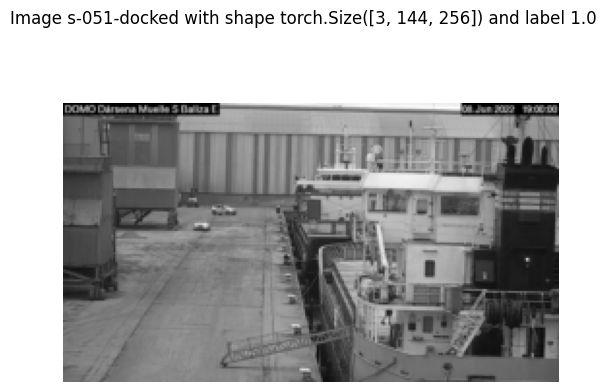

In [6]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

#### Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [7]:
model = squeezenet1_0(weights=None)
#print(model)

In [8]:
class Tail:
    def __init__(self):
        self.model = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size = 1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


mymodel_no_da = nn.Sequential(
    model.features,
    Tail().model
)

image = image.unsqueeze(0)

output = mymodel_no_da(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship. Dada una imagen de entrada predecir la presencia o ausencia de barcos en la escena. Partiendo de un modelo de red base:

### Entrenamiento y validación desde cero, con y sin data augmentation (2 modelos)

In [9]:
# 60-20-20
train_indices, test_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)
test_dataset = data.Subset(ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
from copy import deepcopy

def train_model(model, train_loader, val_loader, loss_fn, optim, device, model_name, epochs=20, ES_patience=3):
    print("Device:", device)
    model.to(device)

    train_losses, val_losses = list(), list()

    best_val_loss = np.inf
    best_model_weights = None
    best_epoch = -1

    patience = ES_patience
    epochs_without_improvement = 0

    for epoch in range(epochs):
        start_time = time.time()

        model.train() # modo train

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        model.eval() # modo evaluación
        val_loss = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}],",
              f"train loss: {train_loss:.4f},",
              f"val loss: {val_loss:.4f},",
              f"time: {(time.time() - start_time):.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Parando el entrenamiento de forma temprana...")
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"El mejor modelo era el de la epoch {best_epoch+1} con una pérdida de validación de {best_val_loss:.4f}")
    torch.save(model.state_dict(), f"{model_name}.pth")

    return model, train_losses, val_losses

def plot_history(train, val):
    plt.clf()
    plt.plot(train, label="train")
    plt.plot(val, label="validation")
    plt.legend(loc="upper right")
    plt.show()

#### Sin Data Augmentation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA",
                                                epochs=99,
                                                ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.6489, val loss: 0.6905, time: 0.75s
Epoch [2/99], train loss: 0.6688, val loss: 0.6629, time: 0.37s
Epoch [3/99], train loss: 0.6092, val loss: 0.6624, time: 0.37s
Epoch [4/99], train loss: 0.6151, val loss: 0.6422, time: 0.37s
Epoch [5/99], train loss: 0.5819, val loss: 0.6304, time: 0.36s
Epoch [6/99], train loss: 0.5681, val loss: 0.6155, time: 0.36s
Epoch [7/99], train loss: 0.5591, val loss: 0.5936, time: 0.37s
Epoch [8/99], train loss: 0.5566, val loss: 0.5695, time: 0.37s
Epoch [9/99], train loss: 0.4881, val loss: 0.5522, time: 0.38s
Epoch [10/99], train loss: 0.4608, val loss: 0.7169, time: 0.37s
Epoch [11/99], train loss: 0.8311, val loss: 0.7721, time: 0.38s
Epoch [12/99], train loss: 0.4221, val loss: 0.5404, time: 0.38s
Epoch [13/99], train loss: 0.5994, val loss: 0.5907, time: 0.38s
Epoch [14/99], train loss: 0.4628, val loss: 0.5909, time: 0.37s
Epoch [15/99], train loss: 0.4488, val loss: 0.5828, time: 0.37s
Epoch [16/99], trai

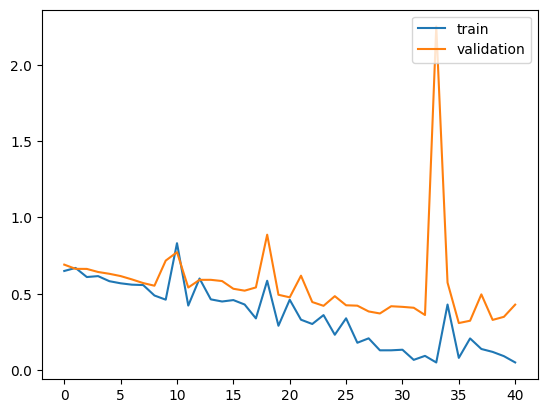

In [12]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [13]:
# Definimos las transformaciones con redimensionamiento y data augmentation
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)

aug_train_dataset = data.Subset(augmented_ship_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_ship_dataset, val_indices)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

Imágenes en el dataset: 294


In [14]:
# Definimos el modelo
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA",
                                                    epochs=99,
                                                    ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.8373, val loss: 0.7062, time: 0.43s
Epoch [2/99], train loss: 0.6789, val loss: 0.6757, time: 0.37s
Epoch [3/99], train loss: 0.6185, val loss: 0.7111, time: 0.37s
Epoch [4/99], train loss: 0.6348, val loss: 0.6655, time: 0.38s
Epoch [5/99], train loss: 0.6368, val loss: 0.6550, time: 0.37s
Epoch [6/99], train loss: 0.5919, val loss: 0.6864, time: 0.38s
Epoch [7/99], train loss: 0.5941, val loss: 0.6427, time: 0.37s
Epoch [8/99], train loss: 0.5566, val loss: 0.6866, time: 0.37s
Epoch [9/99], train loss: 0.5496, val loss: 0.6249, time: 0.37s
Epoch [10/99], train loss: 0.5074, val loss: 0.7433, time: 0.37s
Epoch [11/99], train loss: 0.5538, val loss: 0.6241, time: 0.37s
Epoch [12/99], train loss: 0.4667, val loss: 0.8111, time: 0.37s
Epoch [13/99], train loss: 0.5202, val loss: 0.6246, time: 0.38s
Epoch [14/99], train loss: 0.4405, val loss: 0.8247, time: 0.38s
Epoch [15/99], train loss: 0.4373, val loss: 0.6039, time: 0.38s
Epoch [16/99], trai

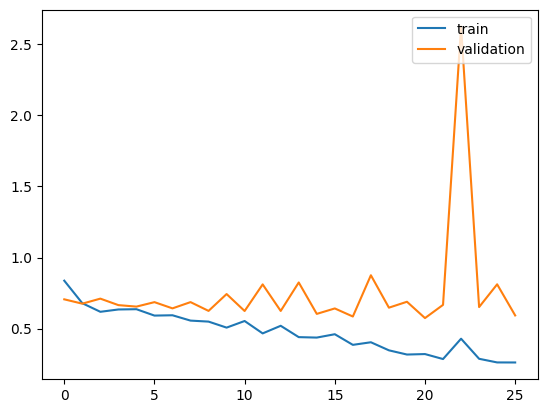

In [16]:
plot_history(train_losses, val_losses)

In [17]:
def accuracy(outputs, targets):
    predicted = (outputs > 0.5).squeeze(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return correct/total

def test_model(model, test_loader):
    print("Device:", device)
    model.eval()

    mean_acc = 0

    with torch.no_grad(): # This disables autograd
        for i, (samples, targets, _) in enumerate(test_loader):
            samples = samples.to(device)
            targets = targets.to(device)

            outputs = model(samples)

            this_acc = accuracy(outputs, targets)

            mean_acc += this_acc

        mean_acc /= (i+1)

    print(f"test accuracy: {(mean_acc*100):.4f} %")

---------------------------------------------------------------------------------------------------------------------------------------

### Refinamiento y validación de modelo preentrenado, con y sin data augmentation (2 modelos).

### Sin Data Augmentation

In [18]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.0001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA",
                                                            epochs=99,
                                                            ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.4981, val loss: 0.5213, time: 0.39s
Epoch [2/99], train loss: 0.4041, val loss: 0.3687, time: 0.38s
Epoch [3/99], train loss: 0.2922, val loss: 0.2817, time: 0.38s
Epoch [4/99], train loss: 0.2034, val loss: 0.1904, time: 0.38s
Epoch [5/99], train loss: 0.1633, val loss: 0.1411, time: 0.38s
Epoch [6/99], train loss: 0.0824, val loss: 0.1219, time: 0.38s
Epoch [7/99], train loss: 0.0536, val loss: 0.1023, time: 0.38s
Epoch [8/99], train loss: 0.0226, val loss: 0.0926, time: 0.38s
Epoch [9/99], train loss: 0.0118, val loss: 0.0737, time: 0.38s
Epoch [10/99], train loss: 0.0062, val loss: 0.0649, time: 0.38s
Epoch [11/99], train loss: 0.0043, val loss: 0.0643, time: 0.38s
Epoch [12/99], train loss: 0.0015, val loss: 0.0506, time: 0.38s
Epoch [13/99], train loss: 0.0010, val loss: 0.0475, time: 0.38s
Epoch [14/99], train loss: 0.0005, val loss: 0.0475, time: 0.38s
Epoch [15/99], train loss: 0.0004, val loss: 0.0542, time: 0.38s
Epoch [16/99], trai

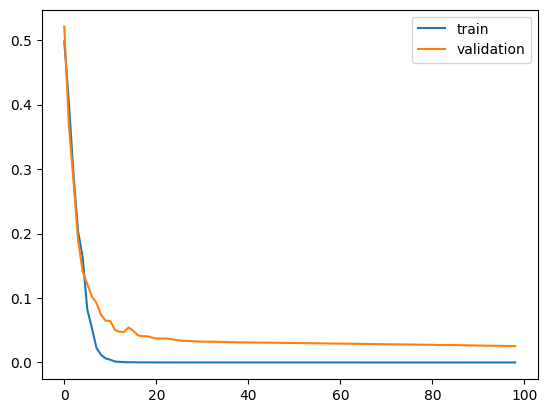

In [19]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [20]:
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.0001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA",
                                                            epochs=99,
                                                            ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.4850, val loss: 0.4373, time: 0.40s
Epoch [2/99], train loss: 0.3275, val loss: 0.2730, time: 0.38s
Epoch [3/99], train loss: 0.2014, val loss: 0.1730, time: 0.39s
Epoch [4/99], train loss: 0.1070, val loss: 0.1282, time: 0.38s
Epoch [5/99], train loss: 0.0668, val loss: 0.1021, time: 0.39s
Epoch [6/99], train loss: 0.0300, val loss: 0.0965, time: 0.39s
Epoch [7/99], train loss: 0.0150, val loss: 0.0790, time: 0.38s
Epoch [8/99], train loss: 0.0066, val loss: 0.0738, time: 0.39s
Epoch [9/99], train loss: 0.0040, val loss: 0.0879, time: 0.39s
Epoch [10/99], train loss: 0.0033, val loss: 0.0715, time: 0.39s
Epoch [11/99], train loss: 0.0013, val loss: 0.0940, time: 0.38s
Epoch [12/99], train loss: 0.0015, val loss: 0.0571, time: 0.39s
Epoch [13/99], train loss: 0.0021, val loss: 0.0623, time: 0.38s
Epoch [14/99], train loss: 0.0009, val loss: 0.0546, time: 0.39s
Epoch [15/99], train loss: 0.0009, val loss: 0.1008, time: 0.38s
Epoch [16/99], trai

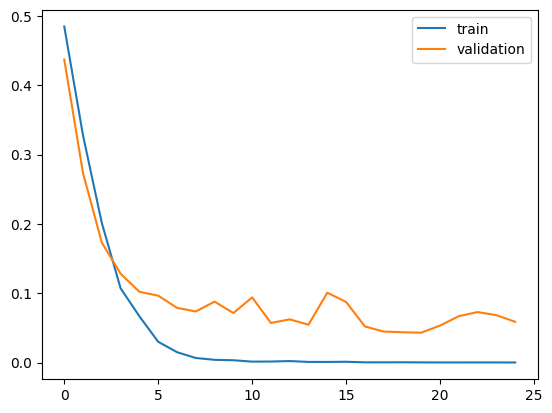

In [21]:
plot_history(train_losses, val_losses)

In [22]:
test_model(mymodel_no_da, test_loader)

Device: cuda:0
test accuracy: 83.0508 %


In [23]:
test_model(mymodel_da, test_loader)

Device: cuda:0
test accuracy: 74.5763 %


In [24]:
test_model(pretrained_no_da, test_loader)

Device: cuda:0
test accuracy: 89.8305 %


In [25]:
test_model(pretrained_da, test_loader)

Device: cuda:0
test accuracy: 91.5254 %
